Importing required libraries

In [27]:
import requests
import json
import datetime
from datetime import datetime as dt
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

Importing Data

In [28]:
key = "pk_f6cf9e2425354ca5b8487526e91b5249"
ticker = "aapl"
prev_yr = "https://cloud.iexapis.com/stable/stock/"+ticker+"/chart/1y?token="+key
prev_day = "https://cloud.iexapis.com/stable/stock/"+ticker+"/chart/1d?token="+key
present_day = "https://cloud.iexapis.com/stable/stock/"+ticker+"/intraday-prices/batch?token="+key

prevyr_data = requests.get(prev_yr)
prevday_data = requests.get(prev_day)
presday_data = requests.get(present_day)
prevyr = json.loads(prevyr_data.text)
prevday = json.loads(prevday_data.text)
presentday = json.loads(presday_data.text)

Converting dates to timestamps

In [29]:
for i in prevyr:
    i['minute'] = i.get('minute','09:30')

for i in prevyr:
        string = i['date']+'T'+i['minute']+':00+00:00'
        element= dt.strptime(string,"%Y-%m-%dT%H:%M:%S+00:00")
        tuple = element.timetuple() 
        timestamp = time.mktime(tuple)
        i['timestamps']= i.get('timestamps',timestamp)

for i in prevday:
        string = i['date']+'T'+i['minute']+':00+00:00'
        element= dt.strptime(string,"%Y-%m-%dT%H:%M:%S+00:00")
        tuple = element.timetuple() 
        timestamp = time.mktime(tuple)
        i['timestamps']= i.get('timestamps',timestamp)

for i in presentday:
        string = i['date']+'T'+i['minute']+':00+00:00'
        element= dt.strptime(string,"%Y-%m-%dT%H:%M:%S+00:00")
        tuple = element.timetuple() 
        timestamp = time.mktime(tuple)
        i['timestamps']= i.get('timestamps',timestamp)

Making DataFrames

In [30]:
pd.set_option("display.precision", 4)

df_prevyr= pd.DataFrame(prevyr)
df_prevday= pd.DataFrame(prevday)
df_presday= pd.DataFrame(presentday)

dataset = pd.concat([df_prevyr, df_prevday, df_presday])
dataset = dataset.drop(['close','high','low','volume','uOpen','uHigh','uLow','uVolume','change','label','changeOverTime','uClose','minute','date','changePercent','average','notional','numberOfTrades'],axis=1)
dataset.head(5)

,open,timestamps
0,56.98,1.5707e+09
1,58.24,1.5708e+09
2,58.73,1.5710e+09
3,59.10,1.5711e+09
4,58.34,1.5712e+09


In [31]:
dataset[dataset==np.inf]=np.nan
dataset.fillna(dataset.mean(), inplace=True)
dataset.timestamps[0:5]

0    1.5707e+09
1    1.5708e+09
2    1.5710e+09
3    1.5711e+09
4    1.5712e+09
Name: timestamps, dtype: float64

Reshaping arrays

In [32]:
array = dataset.values
X = array[:,1]
X = X.reshape(-1,1)
y = array[:,0]

Splitting the data

In [33]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y,test_size=0.3, random_state=3)

Importing models

In [34]:
models = []
models.append((' LR ', LinearRegression()))
models.append((' LASSO ', Lasso()))
models.append((' EN ', ElasticNet()))
models.append((' KNN ', KNeighborsRegressor()))
models.append(('Random Forest',RandomForestRegressor()))
models.append(("Gradient Boosting", GradientBoostingRegressor()))
models.append((' Decison Tree ', DecisionTreeRegressor()))
models.append((' Support Vector ', SVR()))


Evaluating the models

In [35]:
results = []
names = []
for name, model in models:
    kfold = KFold( shuffle=True, random_state=5)
    cv_result = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='r2')
    results.append(cv_result)
    names.append(name)
    print(f'{name} has mean {round(cv_result.mean(), 3)} with standard deviation {round(cv_result.std(), 3)}')

 LR  has mean 0.906 with standard deviation 0.022
 LASSO  has mean 0.906 with standard deviation 0.022
 EN  has mean 0.906 with standard deviation 0.022
 KNN  has mean 0.993 with standard deviation 0.003
Random Forest has mean 0.995 with standard deviation 0.002
Gradient Boosting has mean 0.994 with standard deviation 0.003
 Decison Tree  has mean 0.994 with standard deviation 0.002
 Support Vector  has mean 0.967 with standard deviation 0.009


Plotting models' results 

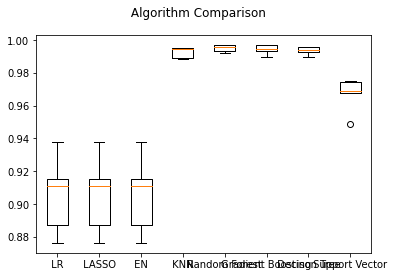

In [36]:
fig = plt.figure()
fig.suptitle(' Algorithm Comparison ')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()


Random Forest Regressor gives the best results and is the model with which we go ahead in this project

Fitting the model

In [37]:
model = RandomForestRegressor(max_depth=20)
model.fit(X_train, y_train)

predictions = model.predict(X_val)
print(r2_score(y_val, predictions))

0.9971789813003713


Plotting the predictions

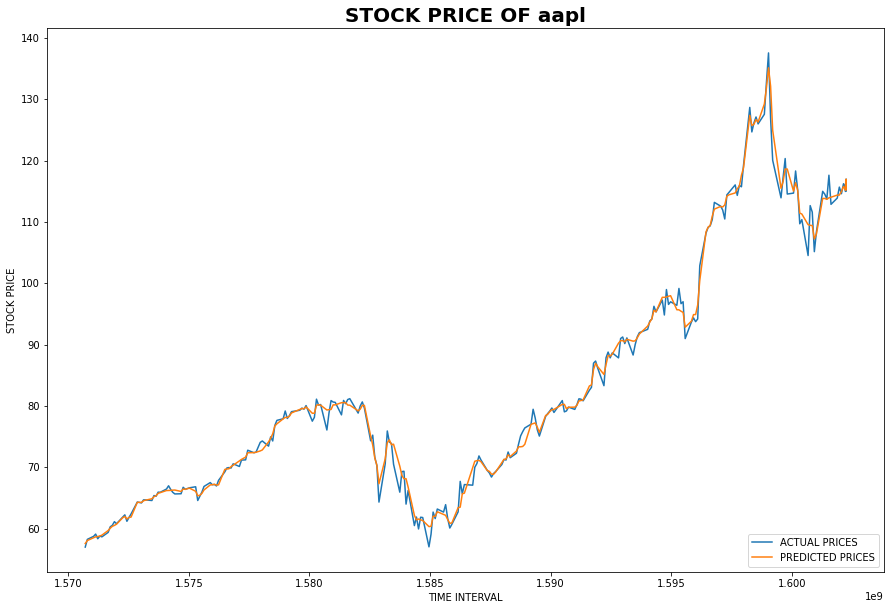

In [38]:
figure = plt.figure(figsize=(15,10))
plt.plot(X, y, label="ACTUAL PRICES")
plt.plot(X, model.predict(X.reshape(-1,1)), label="PREDICTED PRICES")
plt.legend(loc='lower right')
plt.title("STOCK PRICE OF "+ ticker, fontsize=20, fontweight='bold')
plt.xlabel("TIME INTERVAL")
plt.ylabel("STOCK PRICE")
plt.show()